In [2]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

if "../" not in sys.path:
  sys.path.append("../") 
from envs.blackjack import BlackjackEnv
from common import plotting

matplotlib.style.use('ggplot')

In [3]:
env = BlackjackEnv()

In [4]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    蒙特卡罗预测算法。给定策略policy，计算它的价值函数。
    
    参数:
        policy: 一个函数，输入是状态(observation)，输出是采取不同action的概率。
        env: OpenAI gym 环境对象。
        num_episodes: 采样的次数。
        discount_factor:打折因子。
    
    返回:
        一个dictionary state -> value。
        state是一个三元组，而value是float。
    """

    # 记录每个状态的Return和出现的次数。
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # 最终的价值函数
    V = defaultdict(float)
    
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # 生成一个episode.
        # 一个episode是三元组(state, action, reward) 的数组
        episode = []
        state = env.reset()
        for t in range(100):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # 找到这个episode里出现的所有状态。
        states_in_episode = set([tuple(x[0]) for x in episode])
        for state in states_in_episode:
            # 找到这个状态第一次出现的下标
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            # 计算这个状态的Return
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # 累加
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]

    return V    

In [5]:
def sample_policy(observation):
    """
    一个简单的策略：如果不到20就继续要牌，否则就停止要牌。
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

Episode 10000/10000.

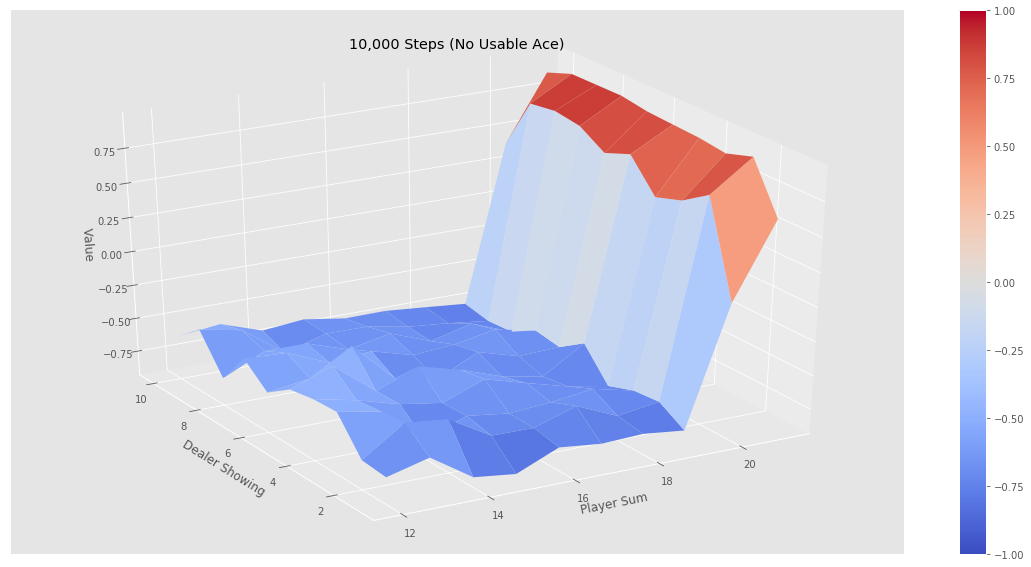

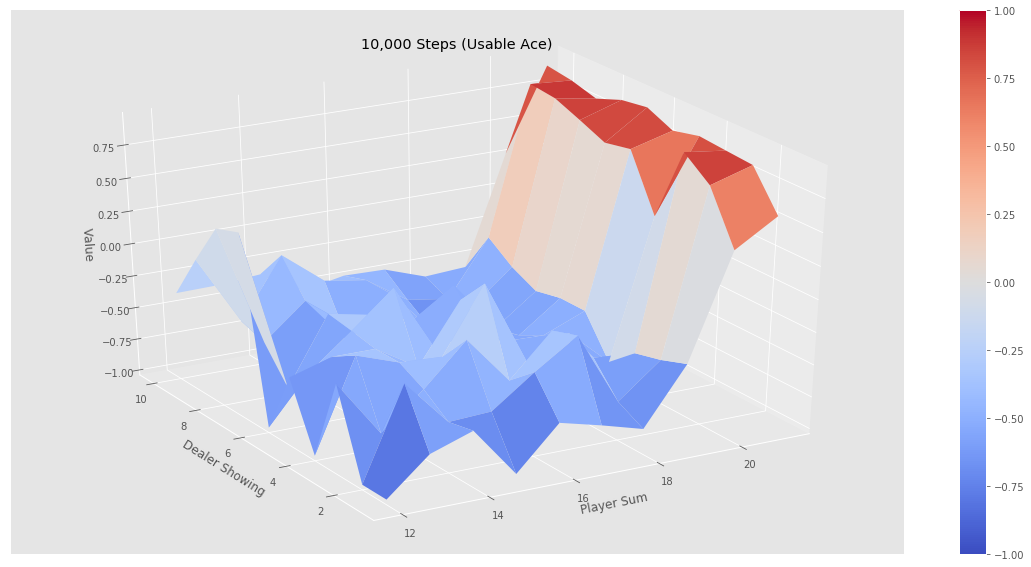

Episode 500000/500000.

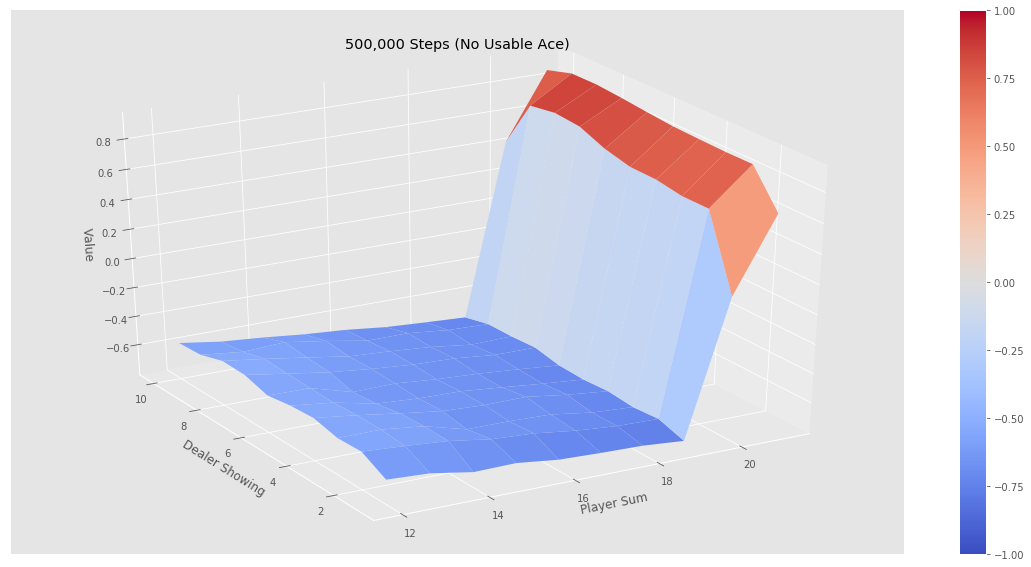

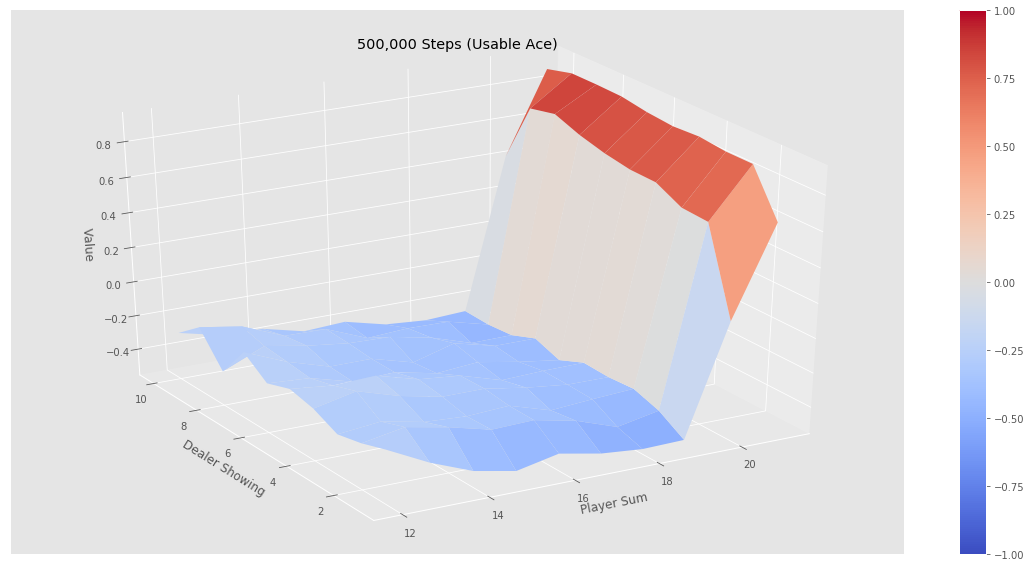

In [6]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")